In [1]:
# include
import timm
import torch
import torch.nn as nn
import torchvision.transforms as T
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR
from pathlib import Path
from pytorch_metric_learning import losses

from PDDD.Codes.modelpy.visual_model.ResNet_50_101_152 import ResNet152
from PDDD.Codes.modelpy.visual_model.MobileNetV3 import mobilenet_v3_small, mobilenet_v3_large

/home/icnlab/anaconda3/envs/aiot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config 
BATCH_SIZE = 32
# NUM_CLASSES = 27
BASE_LR = 0.01
WEIGHT_DECAY = 0.07 #  L2 regularization 
WARMUP_EPOCHS = 2 # Trong 2 epoch đầu, learning rate sẽ được tăng dần từ nhỏ đến BASE_LR
EPOCHS = 100
LAYER_DECAY = 0.8 # (layer) gần đầu vào có learning rate thấp hơn, và các tầng gần đầu ra (cuối mô hình) có learning rate cao hơn
ACCUM_GRAD_STEPS = 1 # Gradient accumulation: để mô phỏng batch size lớn hơn.

DATA_DIR = "/media/icnlab/Data/Manh/tinyML/FieldPlant-11/cropped" 

In [3]:
# load model
def load_Resnet():
    global checkpoint_dir
    model = ResNet152()
    model_path = "/media/icnlab/Data/Manh/tinyML/PDDD/model/ResNet152.std"
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model_name = "/ResNet152_2"
    return model, model_name

def load_MobileNetV3():
    global checkpoint_dir
    model = mobilenet_v3_small()
    model_path = '/media/icnlab/Data/Manh/tinyML/PDDD/model/MobileNetV3.std'
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model_name = "/MobileNetV3"
    return model, model_name

def freeze_model(model):
    for name, param in model.named_parameters():
        if name.startswith(('conv1', 'layer1', 'layer2', 'layer3')):
            param.requires_grad = False
        else:
            param.requires_grad = True
    return model

def compile_model(model):
    try:
        model = torch.compile(model) 
    except Exception:
        pass  

In [4]:
# DataModule
# ----------------------------
class FilteredImageFolder(ImageFolder):
    def __init__(self, root, included_classes, **kwargs):
        super().__init__(root, **kwargs)
        # Lưu lại các chỉ số class cần giữ
        included_indices = [self.class_to_idx[cls] for cls in included_classes]
        self.samples = [s for s in self.samples if s[1] in included_indices]
        self.targets = [s[1] for s in self.samples]

class LightningDataset(pl.LightningDataModule):
    # init dataset, split, transform, dataloader
    def __init__(self, data_dir, batch_size, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
        super().__init__()
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        
        # Define separate transforms for training (with augmentation) and evaluation
        self.train_transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
            T.RandomRotation(degrees=15),    # Randomly rotate images by up to 15 degrees
            T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Random color adjustments
            T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translations
            T.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective changes
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
        ])
        
        # Transform for validation and testing (no augmentation)
        self.eval_transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.416, 0.468, 0.355],   # normalize
                                std=[0.210, 0.206, 0.213])
        ])  # in PDDD paper
        
        # Ensure ratios sum to 1
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Ratios must sum to 1"
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio

    def setup(self, stage=None):
        # Load the full dataset with eval transform initially
        self.full_dataset = ImageFolder(self.data_dir, transform=self.eval_transform)
        # bug
        # included = ['Tomato Brown Spots', 'Tomato blight leaf', 'Tomato healthy', 'Tomato leaf yellow virus']
        # self.full_dataset = FilteredImageFolder(self.data_dir, included, transform=self.eval_transform)
        
    # Calculate split sizes
        dataset_size = len(self.full_dataset)
        train_size = int(dataset_size * self.train_ratio)
        val_size = int(dataset_size * self.val_ratio)
        test_size = dataset_size - train_size - val_size
        
        # Split the dataset
        from torch.utils.data import random_split
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            self.full_dataset,
            [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)  # For reproducibility
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8)
        
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8)

In [5]:
# Layer-wise LR decay helper
# ----------------------------
def get_layer_decay_param_groups(model, base_lr, weight_decay, layer_decay):
    param_groups = []
    layers = list(model.named_parameters())
    num_layers = len(layers)

    for i, (name, param) in enumerate(layers):
        if not param.requires_grad:
            continue
        lr = base_lr * (layer_decay ** (num_layers - i - 1))
        param_groups.append({
            "params": [param],
            "lr": lr,
            "weight_decay": weight_decay if param.ndim >= 2 else 0.0
        })
    return param_groups

In [7]:
# Lightning Module 1: keep_all
# ----------------------------
train_style = '/keep_all'
class EVA02Lightning(pl.LightningModule):
    def __init__(self, embedding_dim=2048, projection_dim=128):
        super().__init__()
        self.backbone, model_name = load_Resnet()
        self.loss_fn = losses.SupConLoss(temperature=0.07)

    def forward(self, x):
        features = self.backbone(x)
        if len(features.shape) > 2:
            features = features.squeeze()
        normalized_features = nn.functional.normalize(features, dim=0)
        return features, normalized_features

    def training_step(self, batch, batch_idx):
        x, y = batch
        _, normalized_features = self(x)
        loss = self.loss_fn(normalized_features, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        _, normalized_features = self(x)
        val_loss = self.loss_fn(normalized_features, y)
        self.log("val_loss", val_loss, prog_bar=True)

    def configure_optimizers(self):
        param_groups = get_layer_decay_param_groups(self.backbone, BASE_LR, WEIGHT_DECAY, LAYER_DECAY)
        optimizer = torch.optim.AdamW(param_groups, eps=1e-6)

        def lr_schedule_fn(current_step):
            if current_step < WARMUP_EPOCHS:
                return float(current_step) / float(max(1, WARMUP_EPOCHS))
            else:
                progress = float(current_step - WARMUP_EPOCHS) / float(max(1, EPOCHS - WARMUP_EPOCHS))
                return max(0.0, 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.1415926535))))

        scheduler = {
            "scheduler": LambdaLR(optimizer, lr_lambda=lr_schedule_fn),
            "interval": "epoch",
            "frequency": 1,
        }
        return [optimizer], [scheduler]


In [ ]:
# Lightning Module: add reLU + Linear
class EVA02Lightning(pl.LightningModule):
    def __init__(self, embedding_dim=1024, projection_dim=128):
        super().__init__()
        self.backbone = load_MobileNetV3()
        global checkpoint_dir
        checkpoint_dir = checkpoint_dir + "/add_relu_linear"



        # for name, param in model.named_parameters():
        #     if name.startswith(('conv1', 'layer1', 'layer2', 'layer3')):
        #         param.requires_grad = False
        #     else:
        #         param.requires_grad = True

        # Thêm ReLU và lớp Linear mới sau backbone
        self.relu = nn.ReLU()
        self.embedding_head = nn.Linear(embedding_dim, projection_dim)

        # Contrastive loss
        self.loss_fn = losses.SupConLoss(temperature=0.07)

    def forward(self, x):
        features = self.backbone(x)
        # if len(features.shape) > 2:
        #     features = features.squeeze()

        # Thêm ReLU và Linear
        features = self.relu(features)
        features = self.embedding_head(features)

        normalized_features = nn.functional.normalize(features, dim=1)
        return features, normalized_features

    def training_step(self, batch, batch_idx):
        x, y = batch
        _, normalized_features = self(x)
        loss = self.loss_fn(normalized_features, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        _, normalized_features = self(x)
        val_loss = self.loss_fn(normalized_features, y)
        self.log("val_loss", val_loss, prog_bar=True)

    def configure_optimizers(self):
        param_groups = get_layer_decay_param_groups(self.backbone, BASE_LR, WEIGHT_DECAY, LAYER_DECAY)

        param_groups.append({
            "params": self.embedding_head.parameters(), 
            "lr": BASE_LR, 
            "weight_decay": WEIGHT_DECAY
        })

        optimizer = torch.optim.AdamW(param_groups, eps=1e-6)

        def lr_schedule_fn(current_step):
            if current_step < WARMUP_EPOCHS:
                return float(current_step) / float(max(1, WARMUP_EPOCHS))
            else:
                progress = float(current_step - WARMUP_EPOCHS) / float(max(1, EPOCHS - WARMUP_EPOCHS))
                return max(0.0, 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.1415926535))))

        scheduler = {
            "scheduler": LambdaLR(optimizer, lr_lambda=lr_schedule_fn),
            "interval": "epoch",
            "frequency": 1,
        }
        return [optimizer], [scheduler]


In [ ]:
# Lightning Module: replace Linear by projection_head, 
# ----------------------------
class EVA02Lightning(pl.LightningModule):
    def __init__(self, embedding_dim=2048, projection_dim=128):
        super().__init__()
        # Load the base model
        model = load_MobileNetV3()

        global checkpoint_dir
        checkpoint_dir = checkpoint_dir + "/projection_head"

    # Add a projection head for contrastive learning
        self.backbone = nn.Sequential(*list(model.children())[:-1])  # Remove final classification layer
        
        self.projection_head = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )
        
        try:
            self.backbone = torch.compile(self.backbone)
        except Exception:
            pass  # torch.compile requires PyTorch 2+

        # Define contrastive loss
        self.loss_fn = losses.SupConLoss(temperature=0.07)

    def forward(self, x):
        # Get embeddings from backbone
        features = self.backbone(x)
        # Handle potential dimension issues
        if len(features.shape) > 2:
            features = features.squeeze()
        # Get projected embeddings
        projections = self.projection_head(features)
        # Normalize projections for contrastive loss
        normalized_projections = nn.functional.normalize(projections, dim=1)
        return features, normalized_projections

    def training_step(self, batch, batch_idx):
        x, y = batch
        
        # Get embeddings and normalized projections
        _, normalized_projections = self(x)
        
        # Calculate contrastive loss
        loss = self.loss_fn(normalized_projections, y)
        
        # Log metrics
        self.log("train_loss", loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        
        # For validation, we'll just log the contrastive loss
        _, normalized_projections = self(x)
        val_loss = self.loss_fn(normalized_projections, y)
        
        # Log metrics
        self.log("val_loss", val_loss, prog_bar=True)
        
        # Since we don't have a classifier, we can't calculate accuracy directly
        # We could implement a nearest-neighbor evaluation here if needed

    def configure_optimizers(self):
        # Get parameters with layer-wise decay for backbone
        param_groups = get_layer_decay_param_groups(self.backbone, BASE_LR, WEIGHT_DECAY, LAYER_DECAY)
        
        # Add projection head parameters
        param_groups.append({
            "params": self.projection_head.parameters(), 
            "lr": BASE_LR, 
            "weight_decay": WEIGHT_DECAY
        })
        
        optimizer = torch.optim.AdamW(param_groups, eps=1e-6)

        def lr_schedule_fn(current_step):
            if current_step < WARMUP_EPOCHS:
                return float(current_step) / float(max(1, WARMUP_EPOCHS))
            else:
                progress = float(current_step - WARMUP_EPOCHS) / float(max(1, EPOCHS - WARMUP_EPOCHS))
                return max(0.0, 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.1415926535))))

        scheduler = {
            "scheduler": LambdaLR(optimizer, lr_lambda=lr_schedule_fn),
            "interval": "epoch",
            "frequency": 1,
        }
        return [optimizer], [scheduler]

In [ ]:
# Train module
# ----------------------------
import time
from datetime import timedelta
import os

# Create checkpoints directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)
pl.seed_everything(42)
dataset = LightningDataset(DATA_DIR, BATCH_SIZE)
model = EVA02Lightning()
# model = EVA02Lightning.load_from_checkpoint('/media/icnlab/Data/Manh/tinyML/checkpoints/keep_all/eva02-00-2.60-0.00.ckpt')

# Define checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath= checkpoint_dir,
    filename="eva02-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,  # Save best models
    save_last=True,  # Additionally save the last model
    verbose=True,
    auto_insert_metric_name=False
)
# Add early stopping callback (optional)
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,  # Stop if no improvement for 5 epochs
    mode="min",
    verbose=True
)

# Add timer callback to track training time
class TimingCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_start_time = None
        self.training_start_time = None
        self.epoch_times = []
    
    def on_train_start(self, trainer, pl_module):
        self.training_start_time = time.time()
        print(f"Training started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    def on_train_epoch_start(self, trainer, pl_module):
        self.epoch_start_time = time.time()
        if trainer.current_epoch > 0 and len(self.epoch_times) > 0:
            avg_epoch_time = sum(self.epoch_times) / len(self.epoch_times)
            remaining_epochs = trainer.max_epochs - trainer.current_epoch
            est_remaining_time = avg_epoch_time * remaining_epochs
            print(f"Estimated time remaining: {timedelta(seconds=int(est_remaining_time))}")
    
    def on_train_epoch_end(self, trainer, pl_module):
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - self.epoch_start_time
        self.epoch_times.append(epoch_time)

        print(f"Epoch {trainer.current_epoch} completed in: {timedelta(seconds=int(epoch_time))}")

        if len(self.epoch_times) > 0:
            avg_epoch_time = sum(self.epoch_times) / len(self.epoch_times)
            remaining_epochs = trainer.max_epochs - trainer.current_epoch - 1
            est_remaining_time = avg_epoch_time * remaining_epochs

            print(f"Average epoch time: {timedelta(seconds=int(avg_epoch_time))}")
            print(f"Estimated time remaining: {timedelta(seconds=int(est_remaining_time))}")
    
    def on_train_end(self, trainer, pl_module):
        total_time = time.time() - self.training_start_time
        print(f"\nTraining completed in: {timedelta(seconds=int(total_time))}")
        print(f"Finished at: {time.strftime('%Y-%m-%d %H:%M:%S')}")

timing_callback = TimingCallback()

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accumulate_grad_batches=ACCUM_GRAD_STEPS,
    precision="16-mixed",
    gradient_clip_val=1.0,
    accelerator="gpu",
    devices="auto",  # multi-GPU nếu có
    # strategy="ddp_find_unused_parameters_false", 
    log_every_n_steps=10,
    callbacks=[checkpoint_callback, early_stop_callback, timing_callback],  # Add callbacks here
)

# Run trainer
trainer.fit(model, datamodule=dataset, 
# ckpt_path= '/media/icnlab/Data/Manh/tinyML/checkpoints/MobileNetV3/keep_all/eva02-10-2.38-0.00.ckpt'
)

# Print path to best model checkpoint
print(f"Best model checkpoint: {checkpoint_callback.best_model_path}")
print(f"Best model score: {checkpoint_callback.best_model_score:.4f}")

### Evaluate model

In [ ]:
# load model
# best_model = EVA02Lightning.load_from_checkpoint(checkpoint_callback.best_model_path)
model = EVA02Lightning.load_from_checkpoint('/media/icnlab/Data/Manh/tinyML/checkpoints/Resnet152/keep_all/eva02-00-3.31-0.00.ckpt')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model_name = 'eva02'

In [10]:
# read PDDD data
from collections import Counter

%store -r image_paths labels
labels_list = Counter(labels)

data_name = 'FieldPlant-11'
image_paths[:2], labels[:2], len(image_paths), len(labels)

(['/media/icnlab/Data/Manh/tinyML/FieldPlant-11/cropped/Tomato blight leaf/IMG_20221118_082850_368_jpg.rf.61b5ec99d23a3f0c5a1766e235fb3b6b_1086_Tomato blight leaf.jpg',
  '/media/icnlab/Data/Manh/tinyML/FieldPlant-11/cropped/Tomato blight leaf/IMG_20221118_081723_527_jpg.rf.337930f270075f587a13824248c1e5bd_3814_Tomato blight leaf.jpg'],
 ['Tomato blight leaf', 'Tomato blight leaf'],
 2765,
 2765)

In [11]:
# common utils
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import seaborn as sns
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.416, 0.468, 0.355],   # normalize
                         std=[0.210, 0.206, 0.213])
])  # in PDDD paper

###############################    
def load_image(image_path):
    if image_path.startswith('http'):
        # Download image from URL
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        # Load local image
        image = Image.open(image_path).convert('RGB')
    return image

In [12]:
# new embedding utils
import torch
from torchvision import transforms
from PIL import Image
import faiss
import numpy as np
from tqdm import tqdm
import requests
from io import BytesIO
def model_forward(model_name, tensor):
    match model_name:
        case '' :
            embedding =  model.forward_features(tensor)

        case _:
            # print(tensor.shape)
            output = model(tensor)
            # print(type(output))
            embedding = output[1]
            # embedding = features['pre_head']
            # embedding = torch.nn.functional.normalize(embedding, dim=1)
        
    # print(embedding.shape)
    return embedding
        
def create_embedding(model, image):
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model_forward(model_name,img_tensor)
    return embedding.cpu().squeeze(0)

def create_index(embeddings):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index

def run_model(model,image_paths, labels):
    embeddings = []
    for path, label in tqdm(list(zip(image_paths, labels)), desc="Extract embeddings"):  # giới hạn 300 ảnh
        img = Image.open(path).convert("RGB")
        embedding = create_embedding(model, img)
        embeddings.append(embedding)
        
    labels = labels[:len(embeddings)]
    embeddings_np = np.array(embeddings).astype("float32")
    # hook_handle.remove()  
    return embeddings_np, labels

embeddings_np, labels = run_model(model, image_paths, labels)
index = create_index(embeddings_np)
embedding_dim = embeddings_np.shape[1]
print(embeddings_np.shape)

Extract embeddings: 100%|██████████| 2765/2765 [01:12<00:00, 38.28it/s]

(2765, 1024)


In [13]:
# Evaluate accuracy
def inference(model,index,embedding, i):
        query_vec = embedding.reshape(1, -1)
        distance, result = index.search(query_vec, k=2)  # i: nearest vector, D: distance
        top1 = result[0][1] if result[0][0] == i else result[0][0]
        # top1 = result[0][0]
        return top1, distance

# Evaluate
def evaluate(index, labels, embeddings):
    correct = 0
    total = len(labels)
    pred_labels = []
    distances = []
    for i in tqdm(range(len(embeddings))):
        top1, distance = inference(model,index,embeddings[i],i)
        pred_labels.append(labels[top1])
        distances.append(distance)
        if labels[i] == labels[top1]:
            correct += 1

    accuracy = correct / len(embeddings)
    return accuracy, pred_labels, distances

accuracy, pred_labels, distances = evaluate(index, labels, embeddings_np)
'Accuracy:'+ str(accuracy), pred_labels[:3], distances[:2]

100%|██████████| 2765/2765 [00:00<00:00, 3067.54it/s]


('Accuracy:0.8723327305605787',
 ['Tomato blight leaf', 'Tomato blight leaf', 'Tomato blight leaf'],
 [array([[ 0., 16.]], dtype=float32), array([[ 0., 24.]], dtype=float32)])

In [14]:
# Clustering metrics 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from collections import Counter
import torch
from torchvision import datasets, transforms, models
from tqdm import tqdm

def evaluate_clustering(embeddings, labels):
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    
    # Get number of unique classes for k-means
    k = len(np.unique(labels))
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    pred_clusters = kmeans.fit_predict(embeddings)
    
    # Calculate all metrics
    metrics = {
        'purity': cluster_purity(labels, pred_clusters),
        'ari': adjusted_rand_score(labels, pred_clusters),
        'nmi': normalized_mutual_info_score(labels, pred_clusters),
        'silhouette': silhouette_score(embeddings, pred_clusters)
    }
    
    return metrics, pred_clusters

def cluster_purity(true_labels, cluster_labels):
    cluster_purity_sum = 0
    for cluster in np.unique(cluster_labels):
        indices = np.where(cluster_labels == cluster)[0]
        true_labels_in_cluster = true_labels[indices]
        most_common_label, count = Counter(true_labels_in_cluster).most_common(1)[0]
        cluster_purity_sum += count
    return cluster_purity_sum / len(true_labels)

# Evaluate clustering
metrics, pred_clusters = evaluate_clustering(embeddings_np, labels)

# Print results
print("Clustering Evaluation Results:")
print(f"Cluster Purity: {metrics['purity']:.4f}", end='  ')
print(f"Adjusted Rand Index (ARI): {metrics['ari']:.4f}")
print(f"Normalized Mutual Information (NMI): {metrics['nmi']:.4f}", end='  ')
print(f"Silhouette Score: {metrics['silhouette']:.4f}", end='  ')

Clustering Evaluation Results:
Cluster Purity: 0.8850  Adjusted Rand Index (ARI): 0.6018
Normalized Mutual Information (NMI): 0.5253  Silhouette Score: 0.3180  

(2765, 1024)


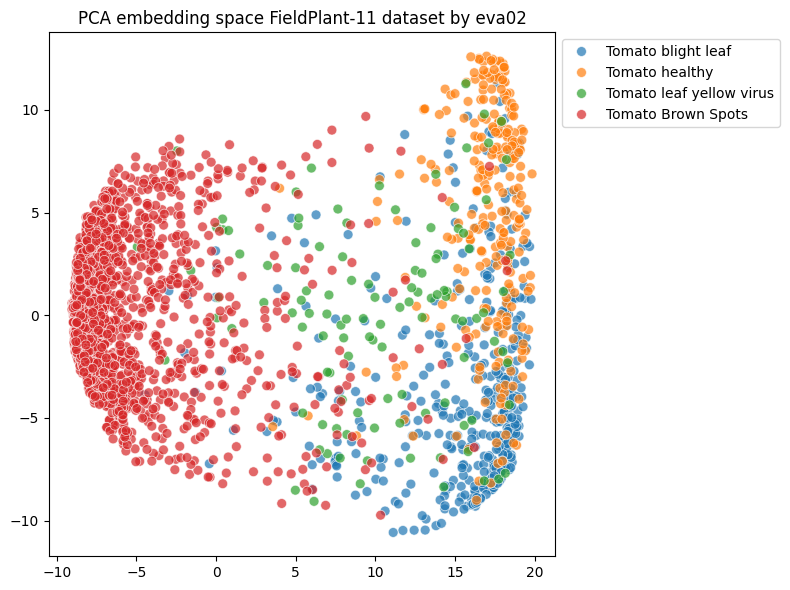

In [15]:
# PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Giảm chiều bằng PCA hoặc t-SNE
print(embeddings_np.shape)
pca = PCA(n_components=3) # n_components <= min(n_samples, n_features)
X_reduced = pca.fit_transform(embeddings_np) # n_features => 2 features,

# Vẽ
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette="tab10", s=50, alpha=0.7)
plt.title(f"PCA embedding space {data_name} dataset by {model_name}")
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
# Vẽ PCA 3D
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
label_encoder = LabelEncoder()
label_ids = label_encoder.fit_transform(labels)  # array of ints

# Dùng label_ids để vẽ màu
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
    c=label_ids,
    cmap='tab10',
    s=50,
    alpha=0.7
)

# Gắn tên class tương ứng với màu
legend_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                             label=cls, markerfacecolor=plt.cm.tab10(i / len(legend_labels)),
                             markersize=8)
                  for i, cls in enumerate(legend_labels)]

ax.set_title(f"PCA 3D embedding of {data_name} dataset by {model_name}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Class")
plt.tight_layout()
plt.show()

In [ ]:
%store embeddings_np labels

### Test

In [ ]:
# for name, param in model.named_parameters():
#     if name.startswith(('backbone.conv1', 'backbone.layer1',)):
#         print(name, param.shape)
#     break

# projection_head_layer = model.projection_head
# Linear_layer = model.projection_head[2]
# Linear_layer

In [ ]:
# Test
image = load_image(image_paths[0])
img_tensor = transform(image).unsqueeze(0).to(device)
output = model.forward(img_tensor)
output[1].shape

embedding = output[1].cpu().squeeze(0)
embeddings = []
embeddings.append(embedding)
embeddings_np = np.array(embeddings).astype("float32")
embeddings_np[0].shape
